# cf_guidance

> Transforms for Classifier-free Guidance Diffusion

This library has normalizations and schedules for the Classifier-free Guidance parameter in Diffusion models. We call the guidance modifiers `transforms`.  

It seems that `transforms` can improve the quality of generated images across Diffusion pipelines. To be specific:  

- Normalizing can help with image syntax.  
- Scheduling can improve image details.  


For more details, please check out the official [blog post](https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-1/).

## Install

```sh
pip install cf_guidance
```

## How to use

The follow section creates a few example schedules. Then, we use the schedules to initialize different kinds of `transforms`.  

### Creating Cosine schedules

We create a few different schedules:  

A Cosine schedule that starts from the default Guidance parameter in diffusion $\left( G = 7.5\right)$ and works it way down to a minimum of $0.15$.  

Next we create the same schedule, except with an initial `warmup`. With warmup, $G$ starts from $0.15$ and linearly works up to a maximum $G_\text{max} = 7.5$. Here we warmup over the first 10% of the total diffusion steps. After warmup, the schedule decreases following a cosine curve.  

Finally, we create a schedule with small values of $G$. This is meant for the guidance transform `TNormGuidance`. This transforms puts the vectors on a similar scale, so we need a much smaller value than usual when mixing them. 

In [ ]:
from cf_guidance.schedules import get_cos_sched

In [ ]:
# Parameters from the blog post
max_val = 7.5
min_val = 0.15
num_steps = 50
num_warmup_steps = 5


# 1) Baseline cosine schedule
cos_params = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_warmup_steps':  0,
}

# 2) Cosine schedule with warmup 
warmup_cos_params = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'warmup_init_val':   min_val + 1., # to show we can offset the warmup relative to min
    'num_warmup_steps':  num_warmup_steps,
}

# 3) Cosine schedule with small values for T-Norm guidance
t_scale_params = {
    'max_val':         0.25,
    'num_steps':       num_steps,
    'min_val':         0.05,
}

# create the schedules
cos_g = get_cos_sched(**cos_params)
warmup_g = get_cos_sched(**warmup_cos_params)
TNorm_g = get_cos_sched(**t_scale_params)

Let's plot these schedules to see what they look like. 

In [ ]:
import matplotlib.pyplot as plt

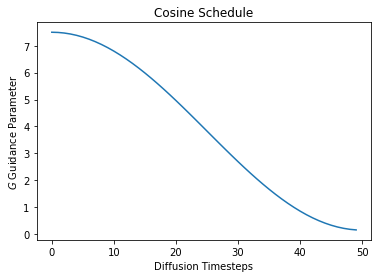

In [ ]:
# plot them 
plt.plot(cos_g)
plt.xlabel('Diffusion Timesteps')
plt.ylabel('$G$ Guidance Parameter')
plt.title('Cosine Schedule');

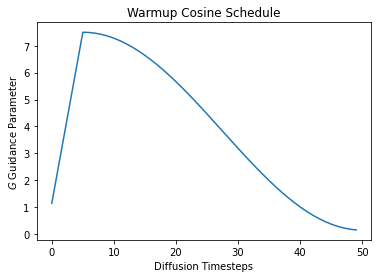

In [ ]:
plt.plot(warmup_g)
plt.xlabel('Diffusion Timesteps')
plt.ylabel('$G$ Guidance Parameter')
plt.title('Warmup Cosine Schedule');

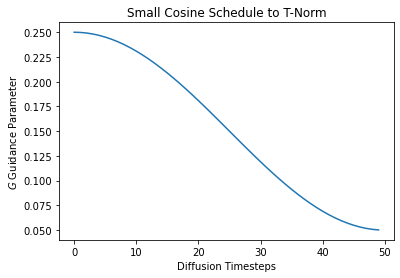

In [ ]:
plt.plot(TNorm_g)
plt.xlabel('Diffusion Timesteps')
plt.ylabel('$G$ Guidance Parameter')
plt.title('Small Cosine Schedule to T-Norm');

### Creating Guidance Transforms

Guidance transforms take one initialization parameter: `schedules`. This is a map from parameter names to an array-like, indexable sequence of values.  

For a given parameter `name` at diffusion timestep `idx`, the value of `schedules[name][idx]` should be the value of that parameter at the given timestep.  

In this case, we call the parameter $G$ as a lowercase 'g'.  


In [ ]:
from cf_guidance.transforms import *

In [ ]:
# Create a baseline Guidance with cosine schedule. 
sample_sched = {'g': cos_g}
guidance = GuidanceTfm(sample_sched)

# Guidance with normalization and a cosine schedule.
norm_guidance = BaseNormGuidance(sample_sched)

# T-Norm Guidance with the smaller-valued schedule
small_sched = {'g': TNorm_g}
small_guidance = TNormGuidance(small_sched)

### Using the transforms in a Diffusion pipeline

The code snippet below shows where and how these transforms are used in an image `generate()` pipeline. We will use the `norm_guidance` class created above for the example.

Specifically, we call this `norm_tfm` with the following arguments:  

- The unconditioned noise predictions.  
- The conditional noise predictions.  
- The current timestep index.  

We borrow code from the [official `StableDiffusionPipeline`](https://github.com/nateraw/stable-diffusion-videos/blob/main/stable_diffusion_videos/stable_diffusion_pipeline.py#L448) from HuggingFace to show where our `norm_tfm` goes. This seems like a good starting point, since many scripts and functions are based on this HuggingFace script.

```python
    # inside of `StableDiffusionPipeline`
    
    for i, t in enumerate(self.progress_bar(timesteps_tensor)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # NOTE: our transforms go here:
        ###############################
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

            ## OLD UPADTE
            #noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # NEW cf_guidance UPDATE
            noise_pred = norm_guidance(noise_pred_uncond, noise_pred_text, i)
```

### Creating more cosine schedules

The cosine schedule function was based on a combination of the Cosine schedulers in [timm](https://github.com/rwightman/pytorch-image-models/blob/main/timm/scheduler/cosine_lr.py) and [HuggingFace](https://github.com/huggingface/transformers/blob/v4.24.0/src/transformers/optimization.py#L104).  

It has a variety of parameters to support many different schedule combinations, as shown below.

In [ ]:
# using wilder parameters, worth exploring
two_cycles = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_cycles':        1,
    'warmup_init_val':   min_val + 1., # to show we can offset the warmup relative to min
    'num_warmup_steps':  0,
}



k_decay_cos = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_cycles':        1.5,
    'k_decay':           0.7,
    'warmup_init_val':   min_val + 1., # to show we can offset the warmup relative to min
    'num_warmup_steps':  num_warmup_steps,
}

# create the schedules
two_cycle_sched = get_cos_sched(**two_cycles)
k_decay_sched = get_cos_sched(**k_decay_cos)


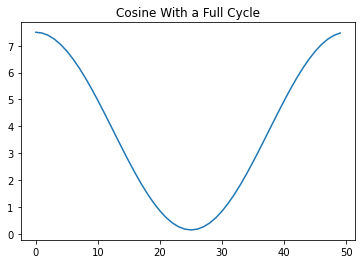

In [ ]:
plt.plot(two_cycle_sched)
plt.title('Cosine With a Full Cycle');

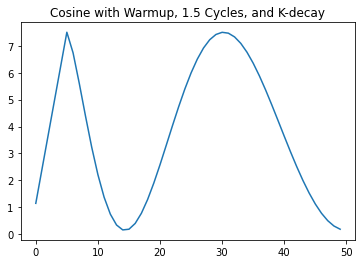

In [ ]:
plt.plot(k_decay_sched)
plt.title('Cosine with Warmup, 1.5 Cycles, and K-decay');